<a href="https://colab.research.google.com/github/drhammed/McGill-Project-Team3/blob/main/montreal_dataset_v1_geojson_171025_Ekue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Montreal Fire Risk Prediction

Here, We try to prepare a panel dataset for predicting neighborhood fire risk in Montreal.

**Output:**
- Binary target variable: Whether a neighborhood experiences at least one fire in a given month
- Spatial structure: 5km x 5km grid cells (maybe we can try 2.5km x 2.5km too? Or perhaps after Wednesday?)
- Temporal structure: Monthly time series (2005-09 onwards)
- Features: Building characteristics, temporal lags, seasonality, spatial lags

**Data Sources:**
1. Fire incidents: `Data/sim_combined_df.csv`
2. Buildings: `Data/montreal_dataset_v1.geojson`
3. Admin boundaries: `Data/EKUE_ASSESSMENTS_DATA/limites-administratives-agglomeration-nad83.geojson`

# Imports

In [2]:
import os
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
#%cd "/content/drive/MyDrive/MCGILL_PROJECT_CAPSTONE/Capstone Project- McGill/Data/"
#%cd "/content/drive/MyDrive/Capstone Project- McGill/Data/"
%cd "/content/drive/MyDrive/Sam_McGill_Project_Team3"

os.getcwd()

/content/drive/MyDrive/Sam_McGill_Project_Team3


'/content/drive/MyDrive/Sam_McGill_Project_Team3'

In [5]:
pwd

'/content/drive/MyDrive/Sam_McGill_Project_Team3'

# Buildings Data: df_Buildings_geo_NAD83

Source:
montreal_dataset/montreal_dataset_v1.geojson
https://ngci.encs.concordia.ca/gitea/CERC/montreal_dataset/src/branch/main/montreal_dataset_v1.geojson

montreal_dataset/README.md
https://ngci.encs.concordia.ca/gitea/CERC/montreal_dataset/src/branch/main/README.md

In [6]:
montreal_dataset_v1_geojson_file_path = 'montreal_dataset_v1.geojson'

montreal_dataset_v1_geojson_gpd = gpd.read_file(montreal_dataset_v1_geojson_file_path, engine='pyogrio')

In [7]:
montreal_dataset_v1_geojson_gpd.head()

,OBJECTID,OBJECTID_1,OBJECTID_12,Z_Min,Z_Max,Z_Mean,OBJECTID_12_13,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,...,OBJECTID_12_13_14_15_16,Join_Count_1,TARGET_FID_1,Shape_Leng_1,Shape_Area_1,MERGE_SRC,NewHieght,Shape_Length,Shape_Area,geometry
0,1,1,1,24.80,36.73,32.352872,1,02005824,,,...,,,,,,,11,0.001077,3.134820e-08,"MULTIPOLYGON (((-73.59561 45.63646, -73.59559 ..."
1,2,2,2,28.44,38.25,36.507502,3,02004842,,,...,,,,,,,9,0.000400,9.041729e-09,"POLYGON ((-73.59498 45.63274, -73.59492 45.632..."
2,3,3,3,34.01,39.63,38.247460,6,02165993,,,...,,,,,,,6,0.001589,5.662433e-08,"MULTIPOLYGON (((-73.58287 45.61064, -73.58287 ..."
3,4,4,4,15.10,23.66,21.400652,14,02010529,,,...,,,,,,,8,0.000639,2.213876e-08,"POLYGON ((-73.57059 45.65817, -73.57044 45.658..."
4,5,5,5,45.83,54.47,52.790334,16,02083902,,,...,,,,,,,9,0.000558,1.637121e-08,"MULTIPOLYGON (((-73.58819 45.57884, -73.58818 ..."


In [8]:
montreal_dataset_v1_geojson_gpd = montreal_dataset_v1_geojson_gpd[montreal_dataset_v1_geojson_gpd['ANNEE_CONS'] != 9999]
display(montreal_dataset_v1_geojson_gpd.head())

,OBJECTID,OBJECTID_1,OBJECTID_12,Z_Min,Z_Max,Z_Mean,OBJECTID_12_13,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,...,OBJECTID_12_13_14_15_16,Join_Count_1,TARGET_FID_1,Shape_Leng_1,Shape_Area_1,MERGE_SRC,NewHieght,Shape_Length,Shape_Area,geometry
0,1,1,1,24.80,36.73,32.352872,1,02005824,,,...,,,,,,,11,0.001077,3.134820e-08,"MULTIPOLYGON (((-73.59561 45.63646, -73.59559 ..."
1,2,2,2,28.44,38.25,36.507502,3,02004842,,,...,,,,,,,9,0.000400,9.041729e-09,"POLYGON ((-73.59498 45.63274, -73.59492 45.632..."
3,4,4,4,15.10,23.66,21.400652,14,02010529,,,...,,,,,,,8,0.000639,2.213876e-08,"POLYGON ((-73.57059 45.65817, -73.57044 45.658..."
4,5,5,5,45.83,54.47,52.790334,16,02083902,,,...,,,,,,,9,0.000558,1.637121e-08,"MULTIPOLYGON (((-73.58819 45.57884, -73.58818 ..."
5,6,6,6,34.49,43.32,41.246754,18,02038600,,,...,,,,,,,9,0.000487,1.321792e-08,"POLYGON ((-73.57867 45.60645, -73.57866 45.606..."


In [9]:
for col in montreal_dataset_v1_geojson_gpd.columns:
  if montreal_dataset_v1_geojson_gpd[col].isnull().sum() > 0:
    print(col,"---",montreal_dataset_v1_geojson_gpd[col].isnull().sum())

In [ ]:
montreal_dataset_v1_geojson_gpd.columns

Index(['OBJECTID', 'OBJECTID_1', 'OBJECTID_12', 'Z_Min', 'Z_Max', 'Z_Mean',
       'OBJECTID_12_13', 'ID_UEV', 'CIVIQUE_DE', 'CIVIQUE_FI', 'NOM_RUE',
       'SUITE_DEBU', 'MUNICIPALI', 'ETAGE_HORS', 'NOMBRE_LOG', 'ANNEE_CONS',
       'CODE_UTILI', 'LETTRE_DEB', 'LETTRE_FIN', 'LIBELLE_UT', 'CATEGORIE_',
       'MATRICULE8', 'SUPERFICIE', 'SUPERFIC_1', 'NO_ARROND_', 'Shape_Leng',
       'OBJECTID_2', 'Join_Count', 'TARGET_FID', 'feature_id', 'md_id',
       'acqtech', 'acqtech_en', 'acqtech_fr', 'provider', 'provideren',
       'providerfr', 'datemin', 'datemax', 'haccmin', 'haccmax', 'vaccmin',
       'vaccmax', 'heightmin', 'heightmax', 'elevmin', 'elevmax', 'bldgarea',
       'comment', 'OBJECTID_3', 'Shape_Le_1', 'Shape_Ar_1', 'OBJECTID_4',
       'Join_Cou_1', 'TARGET_F_1', 'g_objectid', 'g_co_mrc', 'g_code_mun',
       'g_arrond', 'g_anrole', 'g_usag_pre', 'g_no_lot', 'g_nb_poly_',
       'g_utilisat', 'g_nb_logem', 'g_nb_locau', 'g_descript', 'g_id_provi',
       'g_sup_tota', 'g_

In [10]:
for col in montreal_dataset_v1_geojson_gpd.columns:
    print(col,"---",type(montreal_dataset_v1_geojson_gpd[col][0]),"---",montreal_dataset_v1_geojson_gpd[col][0])

OBJECTID --- <class 'numpy.int32'> --- 1
OBJECTID_1 --- <class 'numpy.int32'> --- 1
OBJECTID_12 --- <class 'numpy.int32'> --- 1
Z_Min --- <class 'numpy.float64'> --- 24.8
Z_Max --- <class 'numpy.float64'> --- 36.73
Z_Mean --- <class 'numpy.float64'> --- 32.3528718951
OBJECTID_12_13 --- <class 'numpy.int32'> --- 1
ID_UEV --- <class 'str'> --- 02005824
CIVIQUE_DE --- <class 'str'> --- 
CIVIQUE_FI --- <class 'str'> --- 
NOM_RUE --- <class 'str'> --- boulevard Armand-Bombardier  (MTL)
SUITE_DEBU --- <class 'str'> --- 
MUNICIPALI --- <class 'str'> --- 50
ETAGE_HORS --- <class 'numpy.int32'> --- 2
NOMBRE_LOG --- <class 'numpy.int32'> --- 0
ANNEE_CONS --- <class 'numpy.int32'> --- 1977
CODE_UTILI --- <class 'str'> --- 1000
LETTRE_DEB --- <class 'str'> --- 
LETTRE_FIN --- <class 'str'> --- 
LIBELLE_UT --- <class 'str'> --- Logement
CATEGORIE_ --- <class 'str'> --- Régulier
MATRICULE8 --- <class 'str'> --- 9755-31-6579-2-000-0000
SUPERFICIE --- <class 'numpy.int32'> --- 0
SUPERFIC_1 --- <class 

In [11]:
print(montreal_dataset_v1_geojson_gpd.dtypes)

OBJECTID           int32
OBJECTID_1         int32
OBJECTID_12        int32
Z_Min            float64
Z_Max            float64
                  ...   
MERGE_SRC         object
NewHieght          int32
Shape_Length     float64
Shape_Area       float64
geometry        geometry
Length: 88, dtype: object


In [12]:
montreal_dataset_v1_geojson_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 466775 entries, 0 to 480242
Data columns (total 88 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   OBJECTID                 466775 non-null  int32   
 1   OBJECTID_1               466775 non-null  int32   
 2   OBJECTID_12              466775 non-null  int32   
 3   Z_Min                    466775 non-null  float64 
 4   Z_Max                    466775 non-null  float64 
 5   Z_Mean                   466775 non-null  float64 
 6   OBJECTID_12_13           466775 non-null  int32   
 7   ID_UEV                   466775 non-null  object  
 8   CIVIQUE_DE               466775 non-null  object  
 9   CIVIQUE_FI               466775 non-null  object  
 10  NOM_RUE                  466775 non-null  object  
 11  SUITE_DEBU               466775 non-null  object  
 12  MUNICIPALI               466775 non-null  object  
 13  ETAGE_HORS               466775 non-null 

In [13]:
montreal_dataset_v1_geojson_gpd.shape

(466775, 88)

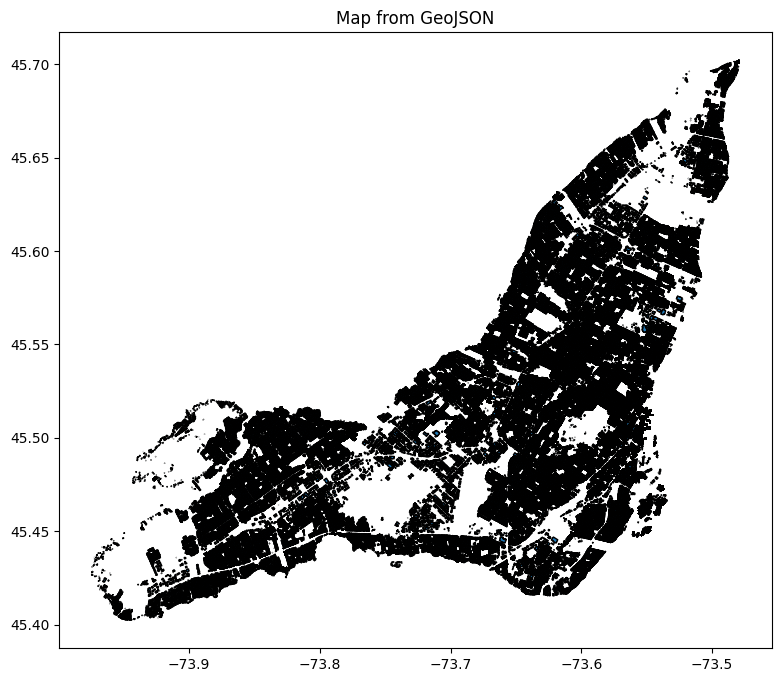

In [14]:
# Plot
montreal_dataset_v1_geojson_gpd.plot(figsize=(10, 8), edgecolor='black')
plt.title("Map from GeoJSON")
plt.show()

# Administrative Boundaries: montreal_admn_lmt_geo_NAD83

Source: administrative-limits-agglomeration-nad83

In [19]:
#geojson_file_path = 'EKUE_ASSESSMENTS_DATA/limites-administratives-agglomeration-nad83.geojson'
geojson_file_path = 'limites-administratives-agglomeration-nad83 (2).geojson'
montreal_admn_lmt_geo_NAD83 = gpd.read_file(geojson_file_path)

# Display the first few rows of the GeoDataFrame
display(montreal_admn_lmt_geo_NAD83.head(5))

# cleaning up the map data (geometry column in the montreal_admn_lmt_geo_NAD83 dataset)
montreal_admn_lmt_geo_NAD83['geometry']=montreal_admn_lmt_geo_NAD83.buffer(0)

# Changes the map's coordinate system to a specific Quebec standard (EPSG:32188)
montreal_admn_lmt_geo_NAD83=montreal_admn_lmt_geo_NAD83.to_crs(epsg=32188)

,CODEID,NOM,NOM_OFFICIEL,CODEMAMH,CODE_3C,NUM,ABREV,TYPE,COMMENT,DATEMODIF,geometry
0,10,LaSalle,LaSalle,REM17,LAS,18,LS,Arrondissement,None,2023-11-29,"MULTIPOLYGON (((291800.968 5031331.566, 291862..."
1,3,Dollard-des-Ormeaux,Dollard-des-Ormeaux,66142,DDO,11,DO,Ville liée,None,2023-11-29,"MULTIPOLYGON (((277698.951 5035907.484, 277740..."
2,27,Côte-Saint-Luc,Côte-Saint-Luc,66058,CSL,72,CL,Ville liée,None,2023-11-29,"MULTIPOLYGON (((290504.379 5035932.981, 290622..."
3,19,Villeray-Saint-Michel-Parc-Extension,Villeray–Saint-Michel–Parc-Extension,REM25,VSE,26,VS,Arrondissement,None,2023-11-29,"MULTIPOLYGON (((295365.304 5042644.191, 295372..."
4,18,Rosemont-La Petite-Patrie,Rosemont–La Petite-Patrie,REM24,RPP,25,RO,Arrondissement,None,2023-11-29,"MULTIPOLYGON (((299454.771 5049061.793, 299454..."


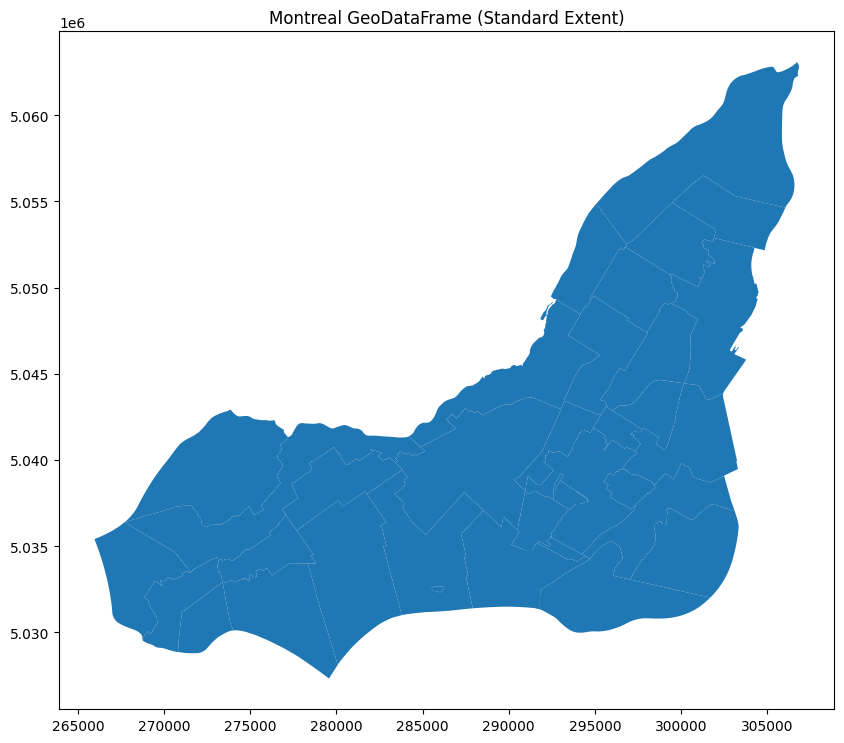

In [20]:
# Recommended standard plot:
montreal_admn_lmt_geo_NAD83.plot(figsize=(10, 10))
plt.title("Montreal GeoDataFrame (Standard Extent)")
plt.show()

In [21]:
# Merges all Montreal geographic shapes into one.
montreal_admn_lmt_geo_NAD83_gmtr = unary_union(montreal_admn_lmt_geo_NAD83.geometry)

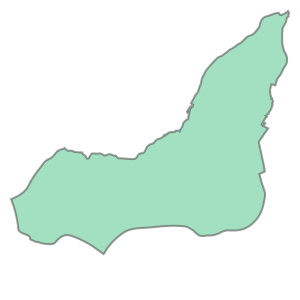

In [22]:
montreal_admn_lmt_geo_NAD83_gmtr

# Create FishNet/Grid for the geographic area of Montreal

In [23]:
#This function creates a grid (fishnet) over a geographic area
def make_fishnet(polygon, cell_size_m=10000, buffer_m=0):
    # Applies an optional buffer (outlining/expansion) to the input area.
    poly = polygon.buffer(buffer_m) if buffer_m != 0 else polygon
    # Finds the bounding box (min/max coordinates) of the area.
    minx, miny, maxx, maxy = poly.bounds

    # Calculates the required number of grid columns and rows based on the cell size.
    n_cols = math.ceil((maxx - minx) / cell_size_m)
    n_rows = math.ceil((maxy - miny) / cell_size_m)

    # Loops through all possible grid cells within the bounding box.
    cells = []
    for r in range(n_rows):
        y1 = miny + r * cell_size_m
        y2 = y1 + cell_size_m
        for c in range(n_cols):
            x1 = minx + c * cell_size_m
            x2 = x1 + cell_size_m
            # Creates a single square grid cell.
            cell = box(x1, y1, x2, y2)
            # Clips the cell to the exact boundary of the input area (e.g., if the area is round).
            if cell.intersects(poly):
                cells.append((r, c, cell.intersection(poly)))

    # Saves the resulting clipped cells into a GeoDataFrame (a table with map data).
    gdf = gpd.GeoDataFrame(cells, columns=["row", "col", "geometry"], crs="EPSG:32188")

    # Attributes - Calculates the area in square kilometers for each clipped cell.
    gdf["area_km2"] = gdf.geometry.area / 1e6

    # fix by Sam based on Gemini input to remove the warning
    # [PART 1 - code commented]
    '''
    # old code
    gdf["cx_mtm8"] = gdf.geometry.centroid.x
    gdf["cy_mtm8"] = gdf.geometry.centroid.y

    # Centroids in WGS84 - Converts coordinates to the common WGS84 standard (Latitude/Longitude).
    gdf_ll = gdf.to_crs(4326)

    # Calculates the center point (centroid) latitude and longitude for each cell.
    gdf["lon"] = gdf_ll.geometry.centroid.x
    gdf["lat"] = gdf_ll.geometry.centroid.y
    '''
    # fix by Sam based on Gemini input to remove the warning
    # [PART 2 - new code to replace the above commented code]
    # --- Start of Centroid Calculation Fix ---

    # 1. Calculate Centroids in the Projected CRS (MTM8/EPSG:32188)
    #    This is the accurate calculation.
    gdf["cx_mtm8"] = gdf.geometry.centroid.x
    gdf["cy_mtm8"] = gdf.geometry.centroid.y

    # 2. Create a new GeoDataFrame of the centroid points using the accurate MTM8 coordinates
    centroids_gdf = gpd.GeoDataFrame(
        gdf.index,
        geometry=gpd.points_from_xy(gdf["cx_mtm8"], gdf["cy_mtm8"], crs="EPSG:32188")
    )

    # 3. Convert the centroid points from MTM8 to WGS 84 (Lat/Lon)
    centroids_wgs84 = centroids_gdf.to_crs(epsg=4326)

    # 4. Extract the correct WGS 84 coordinates (lon/lat) from the reprojected points
    gdf["lon"] = centroids_wgs84.geometry.x
    gdf["lat"] = centroids_wgs84.geometry.y

    # --- End of Centroid Calculation Fix ---

    # Creates a unique ID for each cell using its row and column number.
    # ... (lines after this remain the same)

    # Creates a unique ID for each cell using its row and column number.
    gdf["cell_id"] = gdf["row"].astype(str) + "_" + gdf["col"].astype(str)
    return gdf[["cell_id","row","col","lat","lon","cx_mtm8","cy_mtm8","area_km2","geometry"]]

In [25]:
minx, miny, maxx, maxy = montreal_admn_lmt_geo_NAD83_gmtr.bounds
width = (maxx-minx)/1000.0
length = (maxy-miny)/1000.0
print("width=", width, "KM, length=",length," KM")

width= 40.873781799999996 KM, length= 35.753721808160655  KM


Fishnet Grid Created: 142 cells (approximate).

First 5 cells:
  cell_id  row  col        lat        lon        cx_mtm8       cy_mtm8  \
0     0_1    0    1  45.399943 -73.949352  269620.860919  5.028988e+06   
1     0_2    0    2  45.398764 -73.923396  271652.252445  5.028846e+06   
2     0_3    0    3  45.401861 -73.902327  273303.510146  5.029181e+06   
3     0_4    0    4  45.399112 -73.853734  277106.270036  5.028858e+06   
4     0_5    0    5  45.393847 -73.826166  279262.193347  5.028264e+06   

   area_km2                                           geometry  
0  1.259885  POLYGON ((270461.235 5029324.487, 270461.235 5...  
1  2.349974  POLYGON ((270461.235 5029324.487, 272961.235 5...  
2  0.117764  MULTIPOLYGON (((275461.235 5029324.487, 275461...  
3  1.793211  POLYGON ((275461.235 5029324.487, 277961.235 5...  
4  5.176425  POLYGON ((277961.235 5029324.487, 280461.235 5...  


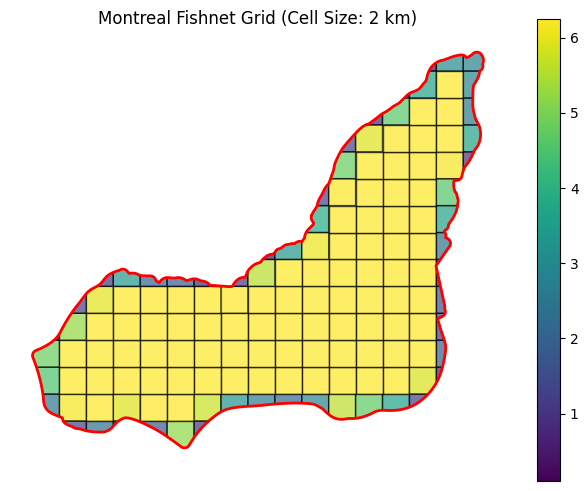

In [26]:
CELL_SIZE = 2500 # 5000 - 1000 meters = 1 km
BUFFER_SIZE = 500 # 500 / Add a 500m buffer around the island

fishnet_grid_gdf = make_fishnet(polygon=montreal_admn_lmt_geo_NAD83_gmtr,cell_size_m=CELL_SIZE, buffer_m=BUFFER_SIZE)

# 3. Print summary and visualize
print(f"Fishnet Grid Created: {len(fishnet_grid_gdf)} cells (approximate).")
print("\nFirst 5 cells:")
print(fishnet_grid_gdf.head())

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fishnet_grid_gdf.plot(ax=ax, edgecolor='black', column='area_km2', legend=True,
                      cmap='viridis', alpha=0.7)

# Overlay the original buffered polygon boundary
gpd.GeoSeries([montreal_admn_lmt_geo_NAD83_gmtr.buffer(BUFFER_SIZE)]).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

ax.set_title(f"Montreal Fishnet Grid (Cell Size: {CELL_SIZE/1000:.0f} km)")
ax.set_axis_off()
plt.show()

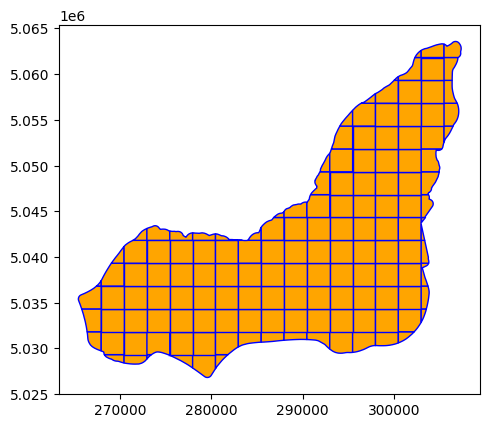

In [27]:
fishnet_grid_gdf.plot(color='orange',edgecolor='blue')
plt.show()

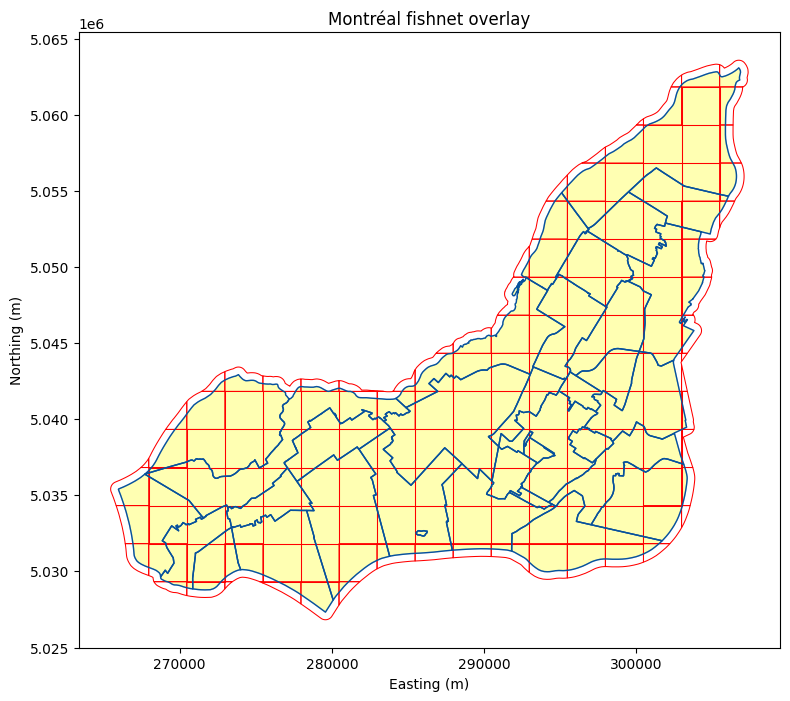

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

# Montréal gdf
montreal_admn_lmt_geo_NAD83.plot(ax=ax, facecolor="#ffff00", edgecolor="#3182bd", alpha=0.3 ) # facecolor="d9f0ff"
montreal_admn_lmt_geo_NAD83.boundary.plot(ax=ax, color="#08519c", linewidth=1)

# Fishnet
fishnet_grid_gdf.plot(ax=ax, facecolor="none", edgecolor="#ff0000", linewidth=0.75)

ax.set_title("Montréal fishnet overlay")
ax.set_aspect("equal")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

# Prepare Fire Data: df_Fire_Final / sim_combined_df

In [29]:
#df_Fire = pd.read_csv('/content/sim_combined_df.csv', engine='python')
df_Fire = pd.read_csv('sim_combined_df.csv', engine='python')
display(df_Fire.head())

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE,CREATION_DATE_FIXED,NOM_ARROND_2,YearMonth,Month,Year,DayOfWeek,"CREATION_DATE_FIXED"""
0,20074,2018/02/22,Alarme privé ou locale,Alarmes-incendies,20,Montréal,Ville-Marie,6,4.0,300599.1,5041118.2,-73.553764,45.509971,2018-02-22,Ville-Marie,2018-02,2,2018,3,2018-02-22
1,45534,2018/05/10,Déchets en feu,AUTREFEU,55,Pointe-Claire,Indéterminé,2,1.0,281760.2,5035568.6,-73.794604,45.459666,2018-05-10,Pointe-Claire,2018-05,5,2018,3,2018-05-10
2,53654,2018/06/02,Appel de Cie de détection,Alarmes-incendies,5,Montréal,Ville-Marie,6,3.0,299523.5,5040741.7,-73.567526,45.506577,2018-06-02,Ville-Marie,2018-06,6,2018,5,2018-06-02
3,54060,2018/06/03,Alarme privé ou locale,Alarmes-incendies,19,Montréal,Ville-Marie,6,3.0,300950.6,5042619.3,-73.549277,45.523481,2018-06-03,Ville-Marie,2018-06,6,2018,6,2018-06-03
4,60405,2018/06/20,Appel de Cie de détection,Alarmes-incendies,76,Westmount,Indéterminé,14,3.0,297496.4,5039104.8,-73.593442,45.491828,2018-06-20,Westmount,2018-06,6,2018,2,2018-06-20


In [30]:
for col in df_Fire.columns:
  if df_Fire[col].isnull().sum() > 0:
    print(col,"---",df_Fire[col].isnull().sum())

MTM8_X --- 198770
MTM8_Y --- 198770


In [31]:
description_groupe_distribution = df_Fire['DESCRIPTION_GROUPE'].value_counts()
print("Distribution of DESCRIPTION_GROUPE:")
print(description_groupe_distribution)

Distribution of DESCRIPTION_GROUPE:
DESCRIPTION_GROUPE
Alarmes-incendies         299064
Autres incendies           38389
AUTREFEU                   30848
Incendies de bâtiments     14593
INCENDIE                   13077
Name: count, dtype: int64


In [32]:
description_groupe_distribution.head(15)

,count
DESCRIPTION_GROUPE,
Alarmes-incendies,299064
Autres incendies,38389
AUTREFEU,30848
Incendies de bâtiments,14593
INCENDIE,13077


In [33]:
df_Fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395971 entries, 0 to 395970
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   INCIDENT_NBR          395971 non-null  int64  
 1   CREATION_DATE_TIME    395971 non-null  object 
 2   INCIDENT_TYPE_DESC    395971 non-null  object 
 3   DESCRIPTION_GROUPE    395971 non-null  object 
 4   CASERNE               395971 non-null  int64  
 5   NOM_VILLE             395971 non-null  object 
 6   NOM_ARROND            395971 non-null  object 
 7   DIVISION              395971 non-null  int64  
 8   NOMBRE_UNITES         395971 non-null  float64
 9   MTM8_X                197201 non-null  float64
 10  MTM8_Y                197201 non-null  float64
 11  LONGITUDE             395971 non-null  float64
 12  LATITUDE              395971 non-null  float64
 13  CREATION_DATE_FIXED   395971 non-null  object 
 14  NOM_ARROND_2          395971 non-null  object 
 15  

In [34]:
# below two column are identical
print("count of different records ", sum(df_Fire['CREATION_DATE_FIXED']!=df_Fire['CREATION_DATE_FIXED"']),"\n",
      "count of identical records ", sum(df_Fire['CREATION_DATE_FIXED']==df_Fire['CREATION_DATE_FIXED"']),"\n",
      "Total # of records: ", df_Fire.shape[0])

count of different records  0 
 count of identical records  395971 
 Total # of records:  395971


In [35]:
#df_Fire = df_Fire.drop(columns=['CREATION_DATE_FIXED"'])

In [36]:
df_Fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395971 entries, 0 to 395970
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   INCIDENT_NBR          395971 non-null  int64  
 1   CREATION_DATE_TIME    395971 non-null  object 
 2   INCIDENT_TYPE_DESC    395971 non-null  object 
 3   DESCRIPTION_GROUPE    395971 non-null  object 
 4   CASERNE               395971 non-null  int64  
 5   NOM_VILLE             395971 non-null  object 
 6   NOM_ARROND            395971 non-null  object 
 7   DIVISION              395971 non-null  int64  
 8   NOMBRE_UNITES         395971 non-null  float64
 9   MTM8_X                197201 non-null  float64
 10  MTM8_Y                197201 non-null  float64
 11  LONGITUDE             395971 non-null  float64
 12  LATITUDE              395971 non-null  float64
 13  CREATION_DATE_FIXED   395971 non-null  object 
 14  NOM_ARROND_2          395971 non-null  object 
 15  

In [37]:
df_Fire_final = df_Fire.rename(columns={'LATITUDE':'latitude', 'LONGITUDE':'longitude'})
df_Fire_final.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,MTM8_X,MTM8_Y,longitude,latitude,CREATION_DATE_FIXED,NOM_ARROND_2,YearMonth,Month,Year,DayOfWeek,"CREATION_DATE_FIXED"""
0,20074,2018/02/22,Alarme privé ou locale,Alarmes-incendies,20,Montréal,Ville-Marie,6,4.0,300599.1,5041118.2,-73.553764,45.509971,2018-02-22,Ville-Marie,2018-02,2,2018,3,2018-02-22
1,45534,2018/05/10,Déchets en feu,AUTREFEU,55,Pointe-Claire,Indéterminé,2,1.0,281760.2,5035568.6,-73.794604,45.459666,2018-05-10,Pointe-Claire,2018-05,5,2018,3,2018-05-10
2,53654,2018/06/02,Appel de Cie de détection,Alarmes-incendies,5,Montréal,Ville-Marie,6,3.0,299523.5,5040741.7,-73.567526,45.506577,2018-06-02,Ville-Marie,2018-06,6,2018,5,2018-06-02
3,54060,2018/06/03,Alarme privé ou locale,Alarmes-incendies,19,Montréal,Ville-Marie,6,3.0,300950.6,5042619.3,-73.549277,45.523481,2018-06-03,Ville-Marie,2018-06,6,2018,6,2018-06-03
4,60405,2018/06/20,Appel de Cie de détection,Alarmes-incendies,76,Westmount,Indéterminé,14,3.0,297496.4,5039104.8,-73.593442,45.491828,2018-06-20,Westmount,2018-06,6,2018,2,2018-06-20


In [39]:
df_Fire_geo_WGS84=gpd.GeoDataFrame(
    df_Fire_final,
    geometry=gpd.points_from_xy(df_Fire_final["longitude"],df_Fire_final["latitude"]),
    crs=4326
    )

# CRS conversion

In [40]:
montreal_admn_lmt_geo_NAD83.crs

<Projected CRS: EPSG:32188>
Name: NAD83 / MTM zone 8
Axis Info [cartesian]:
- E(X)[east]: Easting (metre)
- N(Y)[north]: Northing (metre)
Area of Use:
- name: Canada - Quebec between 75°W and 72°W.; Canada - Ontario - east of 75°W.
- bounds: (-75.0, 44.98, -72.0, 62.53)
Coordinate Operation:
- name: MTM zone 8
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [41]:
montreal_dataset_v1_geojson_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
df_Buildings_geo_NAD83 = montreal_dataset_v1_geojson_gpd.to_crs(montreal_admn_lmt_geo_NAD83.crs)

df_Buildings_geo_NAD83.crs

<Projected CRS: EPSG:32188>
Name: NAD83 / MTM zone 8
Axis Info [cartesian]:
- E(X)[east]: Easting (metre)
- N(Y)[north]: Northing (metre)
Area of Use:
- name: Canada - Quebec between 75°W and 72°W.; Canada - Ontario - east of 75°W.
- bounds: (-75.0, 44.98, -72.0, 62.53)
Coordinate Operation:
- name: MTM zone 8
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [43]:
df_Buildings_geo_NAD83.head()

,OBJECTID,OBJECTID_1,OBJECTID_12,Z_Min,Z_Max,Z_Mean,OBJECTID_12_13,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,...,OBJECTID_12_13_14_15_16,Join_Count_1,TARGET_FID_1,Shape_Leng_1,Shape_Area_1,MERGE_SRC,NewHieght,Shape_Length,Shape_Area,geometry
0,1,1,1,24.80,36.73,32.352872,1,02005824,,,...,,,,,,,11,0.001077,3.134820e-08,"MULTIPOLYGON (((297346.05 5055178.373, 297347...."
1,2,2,2,28.44,38.25,36.507502,3,02004842,,,...,,,,,,,9,0.000400,9.041729e-09,"POLYGON ((297395.103 5054764.59, 297399.577 50..."
3,4,4,4,15.10,23.66,21.400652,14,02010529,,,...,,,,,,,8,0.000639,2.213876e-08,"POLYGON ((299298.96 5057588.857, 299310.207 50..."
4,5,5,5,45.83,54.47,52.790334,16,02083902,,,...,,,,,,,9,0.000558,1.637121e-08,"MULTIPOLYGON (((297917.915 5048773.62, 297917...."
5,6,6,6,34.49,43.32,41.246754,18,02038600,,,...,,,,,,,9,0.000487,1.321792e-08,"POLYGON ((298663.393 5051841.221, 298664.197 5..."


# Building as points NOT as Polygons

In [44]:
# recently modified (14-OCT-2025)
# project to NAD83 / MTM 8 for accurate geometry ops
#gdf_proj = df_Buildings_geo_NAD83.to_crs(2950)  # or 32188 if data is EPSG:4326 (WGS 84)

# pick a stable point inside each polygon
pts_proj = df_Buildings_geo_NAD83.representative_point()   # stays inside; better than centroid for concave shapes
pts_ll   = pts_proj.to_crs(4326)  # back to lon/lat

df_Buildings_geo_NAD83["cntr_longitude"] = pts_ll.x
df_Buildings_geo_NAD83["cntr_latitude"]  = pts_ll.y

In [45]:
# recently modified (14-OCT-2025)
import geopandas as gpd
from shapely.geometry import Point

# Assume df_Buildings_geo_NAD83 is the DataFrame.
# Its main geometry column is in NAD83 (e.g., EPSG:32188).
# The Lat/Lon columns are 'cntr_longitude' and 'cntr_latitude' (in EPSG:4326).

# 1. Define the target NAD83 CRS (Easting/Northing)
# We assume the main geometry and the fishnet grid are both in EPSG:32188.
TARGET_CRS = 'EPSG:32188'

# 2. Create a GeoSeries of Points from the Lat/Lon columns
# IMPORTANT: The CRS must be set to 4326 (WGS 84) to tell GeoPandas what these numbers mean.
points_4326 = gpd.GeoSeries(
    [Point(lon, lat) for lon, lat in zip(
        df_Buildings_geo_NAD83['cntr_longitude'],
        df_Buildings_geo_NAD83['cntr_latitude']
    )],
    crs='EPSG:4326'
)

# 3. Reproject the points to the NAD83 target CRS
# This performs the mathematical conversion from degrees to meters.
points_nad83 = points_4326.to_crs(TARGET_CRS)

# 4. Add the new NAD83 coordinates (Easting/Northing) to the DataFrame
df_Buildings_geo_NAD83['cntr_easting_nad83'] = points_nad83.x    # Easting (X) in meters
df_Buildings_geo_NAD83['cntr_northing_nad83'] = points_nad83.y  # Northing (Y) in meters

# 5. Optional: Create a new geometry column using the NAD83 points for the spatial join
df_Buildings_geo_NAD83['nad83_point_geom'] = points_nad83

In [46]:
df_Buildings_geo_NAD83.head()

,OBJECTID,OBJECTID_1,OBJECTID_12,Z_Min,Z_Max,Z_Mean,OBJECTID_12_13,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,...,MERGE_SRC,NewHieght,Shape_Length,Shape_Area,geometry,cntr_longitude,cntr_latitude,cntr_easting_nad83,cntr_northing_nad83,nad83_point_geom
0,1,1,1,24.80,36.73,32.352872,1,02005824,,,...,,11,0.001077,3.134820e-08,"MULTIPOLYGON (((297346.05 5055178.373, 297347....",-73.595354,45.636468,297366.114845,5.055179e+06,POINT (297366.115 5055179.028)
1,2,2,2,28.44,38.25,36.507502,3,02004842,,,...,,9,0.000400,9.041729e-09,"POLYGON ((297395.103 5054764.59, 297399.577 50...",-73.594893,45.632740,297401.535728,5.054765e+06,POINT (297401.536 5054764.709)
3,4,4,4,15.10,23.66,21.400652,14,02010529,,,...,,8,0.000639,2.213876e-08,"POLYGON ((299298.96 5057588.857, 299310.207 50...",-73.570467,45.658127,297920.870056,5.048789e+06,POINT (297920.87 5048788.792)
4,5,5,5,45.83,54.47,52.790334,16,02083902,,,...,,9,0.000558,1.637121e-08,"MULTIPOLYGON (((297917.915 5048773.62, 297917....",-73.588148,45.578973,298660.298547,5.051848e+06,POINT (298660.299 5051848.351)
5,6,6,6,34.49,43.32,41.246754,18,02038600,,,...,,9,0.000487,1.321792e-08,"POLYGON ((298663.393 5051841.221, 298664.197 5...",-73.578711,45.606511,296966.712992,5.050874e+06,POINT (296966.713 5050873.566)


In [47]:
'''
print(df_Buildings_geo_NAD83.loc[0]['geometry'],
      "\n",df_Buildings_geo_NAD83.loc[0]['cntr_longitude'],
      "\n",df_Buildings_geo_NAD83.loc[0]['cntr_latitude'])
'''

'\nprint(df_Buildings_geo_NAD83.loc[0][\'geometry\'],\n      "\n",df_Buildings_geo_NAD83.loc[0][\'cntr_longitude\'],\n      "\n",df_Buildings_geo_NAD83.loc[0][\'cntr_latitude\'])\n'

In [49]:
# Assuming fishnet_grid_gdf is the fishnet in NAD83 (EPSG:32188)

# Create a temporary GeoDataFrame for the points, using the NAD83 point geometry
buildings_points_gdf = gpd.GeoDataFrame(
    df_Buildings_geo_NAD83.drop(columns=['geometry']), # Drop the polygon geometry
    geometry='nad83_point_geom',                      # Use the new NAD83 point geometry
    crs=TARGET_CRS
)

# Perform the Spatial Join
points_in_grid = gpd.sjoin(
    buildings_points_gdf,
    fishnet_grid_gdf,
    how="left",
    predicate='within'
)

# Create maps and check CRS used for each dataset

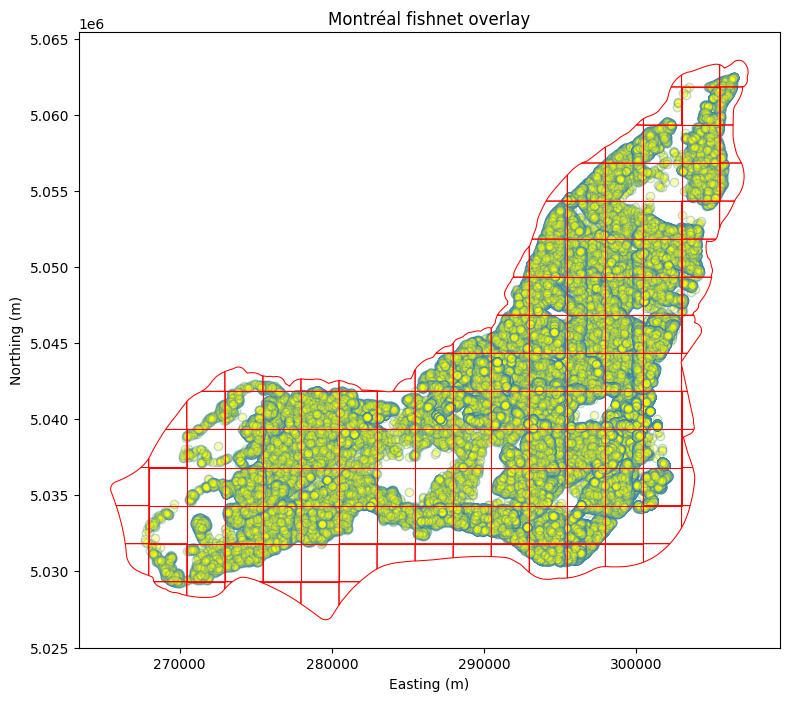

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))

# Montréal gdf
buildings_points_gdf.plot(ax=ax, facecolor="#ffff00", edgecolor="#3182bd", alpha=0.3 ) # facecolor="d9f0ff"
buildings_points_gdf.boundary.plot(ax=ax, color="#08519c", linewidth=1)

# Fishnet
fishnet_grid_gdf.plot(ax=ax, facecolor="none", edgecolor="#ff0000", linewidth=0.75)

ax.set_title("Montréal fishnet overlay")
ax.set_aspect("equal")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [51]:
fishnet_grid_gdf.crs

<Projected CRS: EPSG:32188>
Name: NAD83 / MTM zone 8
Axis Info [cartesian]:
- E(X)[east]: Easting (metre)
- N(Y)[north]: Northing (metre)
Area of Use:
- name: Canada - Quebec between 75°W and 72°W.; Canada - Ontario - east of 75°W.
- bounds: (-75.0, 44.98, -72.0, 62.53)
Coordinate Operation:
- name: MTM zone 8
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [52]:
df_Fire_geo_WGS84.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
df_Fire_geo_NAD83 = df_Fire_geo_WGS84.to_crs(montreal_admn_lmt_geo_NAD83.crs)
df_Fire_geo_NAD83.crs

<Projected CRS: EPSG:32188>
Name: NAD83 / MTM zone 8
Axis Info [cartesian]:
- E(X)[east]: Easting (metre)
- N(Y)[north]: Northing (metre)
Area of Use:
- name: Canada - Quebec between 75°W and 72°W.; Canada - Ontario - east of 75°W.
- bounds: (-75.0, 44.98, -72.0, 62.53)
Coordinate Operation:
- name: MTM zone 8
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [54]:
buildings_points_gdf.crs

<Projected CRS: EPSG:32188>
Name: NAD83 / MTM zone 8
Axis Info [cartesian]:
- E(X)[east]: Easting (metre)
- N(Y)[north]: Northing (metre)
Area of Use:
- name: Canada - Quebec between 75°W and 72°W.; Canada - Ontario - east of 75°W.
- bounds: (-75.0, 44.98, -72.0, 62.53)
Coordinate Operation:
- name: MTM zone 8
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

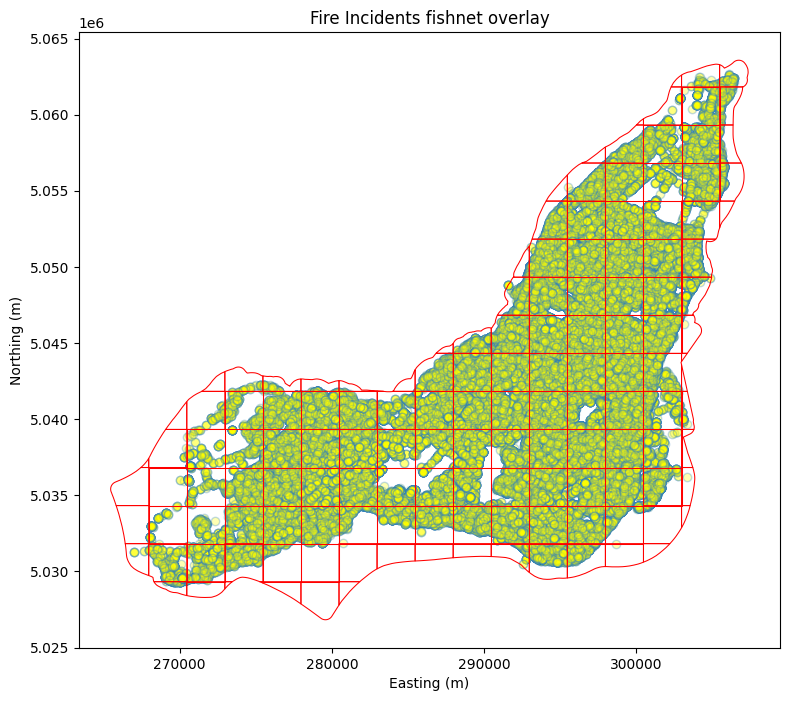

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))

# Montréal gdf
df_Fire_geo_NAD83.plot(ax=ax, facecolor="#ffff00", edgecolor="#3182bd", alpha=0.3 ) # facecolor="d9f0ff"
df_Fire_geo_NAD83.boundary.plot(ax=ax, color="#08519c", linewidth=1)

# Fishnet
fishnet_grid_gdf.plot(ax=ax, facecolor="none", edgecolor="#ff0000", linewidth=0.75)

ax.set_title("Fire Incidents fishnet overlay")
ax.set_aspect("equal")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [56]:
print(
    "df_Fire_geo_NAD83.crs : ", df_Fire_geo_NAD83.crs,
    #"\ndf_Buildings_geo_NAD83.crs : ", df_Buildings_geo_NAD83.crs,
    "\nbuildings_points_gdf.crs : ", buildings_points_gdf.crs,
    "\nmontreal_admn_lmt_geo_NAD83.crs : ",montreal_admn_lmt_geo_NAD83.crs,
    "\nfishnet_grid_gdf.crs : ", fishnet_grid_gdf.crs)

df_Fire_geo_NAD83.crs :  EPSG:32188 
buildings_points_gdf.crs :  EPSG:32188 
montreal_admn_lmt_geo_NAD83.crs :  EPSG:32188 
fishnet_grid_gdf.crs :  EPSG:32188


# Spatial Join / sjoin

In [ ]:
'''
# best
df_Bldgs_leftWithin_fshNetGrd_geo = gpd.sjoin(
    df_Buildings_geo_NAD83,fishnet_grid_gdf, how="left", predicate="within")

# good alternative
df_fshNetGrd_leftContains_Bldgs_geo = gpd.sjoin(
    fishnet_grid_gdf,df_Buildings_geo_NAD83, how="left", predicate="contains")

# below is not recommended - as we lose empty grid cells for visualization.
#
df_Bldgs_innerWithin_fshNetGrd_geo = df_Buildings_geo_NAD83.sjoin(
    fishnet_grid_gdf, how="inner", predicate="within")
#

print("df_Bldgs_leftWithin_fshNetGrd_geo: ", df_Bldgs_leftWithin_fshNetGrd_geo.shape[0],
      "\ndf_fshNetGrd_leftContains_Bldgs_geo: ", df_fshNetGrd_leftContains_Bldgs_geo.shape[0],
      "\ndf_Bldgs_innerWithin_fshNetGrd_geo: ", df_Bldgs_innerWithin_fshNetGrd_geo.shape[0])
'''

In [57]:
# best
df_Bldgs_leftWithin_fshNetGrd_geo = gpd.sjoin(
    buildings_points_gdf,fishnet_grid_gdf, how="left", predicate="within")

# good alternative
df_fshNetGrd_leftContains_Bldgs_geo = gpd.sjoin(
    fishnet_grid_gdf,buildings_points_gdf, how="left", predicate="contains")

# below is not recommended - as we lose empty grid cells for visualization.
#
df_Bldgs_innerWithin_fshNetGrd_geo = buildings_points_gdf.sjoin(
    fishnet_grid_gdf, how="inner", predicate="within")

print("df_Bldgs_leftWithin_fshNetGrd_geo: ", df_Bldgs_leftWithin_fshNetGrd_geo.shape[0],
      "\ndf_fshNetGrd_leftContains_Bldgs_geo: ", df_fshNetGrd_leftContains_Bldgs_geo.shape[0],
      "\ndf_Bldgs_innerWithin_fshNetGrd_geo: ", df_Bldgs_innerWithin_fshNetGrd_geo.shape[0])

df_Bldgs_leftWithin_fshNetGrd_geo:  466775 
df_fshNetGrd_leftContains_Bldgs_geo:  453568 
df_Bldgs_innerWithin_fshNetGrd_geo:  453541


In [58]:
building_counts_df = df_Bldgs_leftWithin_fshNetGrd_geo.groupby(['cell_id']).size().reset_index(name='buildings_count')
building_counts_df

,cell_id,buildings_count
0,0_1,37
1,10_11,3523
2,10_12,3864
3,10_13,1387
4,10_14,4387
...,...,...
110,9_11,6843
111,9_12,5660
112,9_13,8319
113,9_14,6983


In [59]:
building_counts_df.shape

(115, 2)

In [60]:
# best
df_fires_leftWithin_fshNetGrd_geo = gpd.sjoin(
    df_Fire_geo_NAD83, fishnet_grid_gdf, how="left", predicate="within")

# good alternative
df_fshNetGrd_leftContains_fires_geo = gpd.sjoin(
    fishnet_grid_gdf,df_Fire_geo_NAD83, how="left", predicate="contains")

# below is not recommended - as we lose empty grid cells for visualization.
#
df_fires_innerWithin_fshNetGrd_geo = df_Fire_geo_NAD83.sjoin(
    fishnet_grid_gdf, how="inner", predicate="within")
#

print("df_fires_leftWithin_fshNetGrd_geo: ", df_fires_leftWithin_fshNetGrd_geo.shape[0],
      "\ndf_fshNetGrd_leftContains_fires_geo: ", df_fshNetGrd_leftContains_fires_geo.shape[0],
      "\ndf_fires_innerWithin_fshNetGrd_geo: ", df_fires_innerWithin_fshNetGrd_geo.shape[0])

df_fires_leftWithin_fshNetGrd_geo:  395971 
df_fshNetGrd_leftContains_fires_geo:  395990 
df_fires_innerWithin_fshNetGrd_geo:  395963


In [61]:
fireIncidents_counts_df = df_fires_leftWithin_fshNetGrd_geo.groupby(['cell_id']).size().reset_index(name='fireIncidents_count')
fireIncidents_counts_df

,cell_id,fireIncidents_count
0,0_1,37
1,10_11,3054
2,10_12,3890
3,10_13,2351
4,10_14,2224
...,...,...
110,9_11,6417
111,9_12,3919
112,9_13,5570
113,9_14,4450


In [62]:
fireIncidents_counts_df.shape

(115, 2)

In [63]:
bldg_fires_df = pd.merge(building_counts_df, fireIncidents_counts_df, on='cell_id', how='outer')
bldg_fires_df['diff_validate']= bldg_fires_df['buildings_count']-bldg_fires_df['fireIncidents_count'] #.head()
bldg_fires_df['ratio_fires_to_buildings'] = round((bldg_fires_df['fireIncidents_count']/bldg_fires_df['buildings_count']),2)
bldg_fires_df


,cell_id,buildings_count,fireIncidents_count,diff_validate,ratio_fires_to_buildings
0,0_1,37.0,37.0,0.0,1.00
1,10_11,3523.0,3054.0,469.0,0.87
2,10_12,3864.0,3890.0,-26.0,1.01
3,10_13,1387.0,2351.0,-964.0,1.70
4,10_14,4387.0,2224.0,2163.0,0.51
...,...,...,...,...,...
115,9_11,6843.0,6417.0,426.0,0.94
116,9_12,5660.0,3919.0,1741.0,0.69
117,9_13,8319.0,5570.0,2749.0,0.67
118,9_14,6983.0,4450.0,2533.0,0.64


In [ ]:
'''
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np

# 1. Define the WKT string
wkt_polygon = "MULTIPOLYGON (((-73.59561096599998 45.636462047000066, -73.59559452199994 45.636446629000034, -73.59558581999994 45.63643846900004, -73.59558168899997 45.63644076600008, -73.59555158899997 45.63645746600008, -73.59557702099994 45.636479861000055, -73.59561096599998 45.636462047000066)), ((-73.59549148899998 45.636489366000035, -73.59544268899998 45.63644406600008, -73.59536237799995 45.63636988800005, -73.59521554499997 45.636446944000056, -73.59534548899995 45.636566566000056, -73.59535188899997 45.63656296600004, -73.59549148899998 45.636489366000035)), ((-73.59545875699996 45.63631931000003, -73.59541337399997 45.63634312600004, -73.59547278899998 45.63639016600007, -73.59550258899998 45.63637156600004, -73.59545498899996 45.63633416600004, -73.59546685899994 45.63632690900005, -73.59545875699996 45.63631931000003)))"

# 2. Parse the WKT string
geometry = wkt.loads(wkt_polygon)

# 3. Create the plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Representation of MULTIPOLYGON')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal', adjustable='box')

# 4. Iterate and plot each polygon in the MULTIPOLYGON
for i, polygon in enumerate(geometry.geoms):
    # Extract coordinates (Longitude, Latitude)
    x, y = polygon.exterior.xy

    # Plot the polygon's exterior ring
    ax.plot(x, y, color='blue', linewidth=2, solid_capstyle='round')
    # Fill the polygon area
    ax.fill(x, y, color='lightblue', alpha=0.5)

# 5. Set plot limits based on polygon bounds with a small buffer
minx, miny, maxx, maxy = geometry.bounds
buffer = 0.00005
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

# 6. Save the plot
plt.savefig("multipolygon_plot.png")
'''

# Pak's additional codes for creating dataframe.
**Pay attention to the dataframes' names which may have to be changed.**

In [65]:
# check the dtype of CREATION_DATE_FIXED"
df_Fire_geo_NAD83.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 395971 entries, 0 to 395970
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   INCIDENT_NBR          395971 non-null  int64   
 1   CREATION_DATE_TIME    395971 non-null  object  
 2   INCIDENT_TYPE_DESC    395971 non-null  object  
 3   DESCRIPTION_GROUPE    395971 non-null  object  
 4   CASERNE               395971 non-null  int64   
 5   NOM_VILLE             395971 non-null  object  
 6   NOM_ARROND            395971 non-null  object  
 7   DIVISION              395971 non-null  int64   
 8   NOMBRE_UNITES         395971 non-null  float64 
 9   MTM8_X                197201 non-null  float64 
 10  MTM8_Y                197201 non-null  float64 
 11  longitude             395971 non-null  float64 
 12  latitude              395971 non-null  float64 
 13  CREATION_DATE_FIXED   395971 non-null  object  
 14  NOM_ARROND_2          395971

In [66]:
# Convert to datetime and cast to period_array
df_Fire_geo_NAD83['CREATION_DATE_FIXED"'] = pd.to_datetime(df_Fire_geo_NAD83['CREATION_DATE_FIXED"'])
df_Fire_geo_NAD83['year_month'] = df_Fire_geo_NAD83['CREATION_DATE_FIXED"'].dt.to_period('M').astype(str)
df_Fire_geo_NAD83.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,MTM8_X,...,latitude,CREATION_DATE_FIXED,NOM_ARROND_2,YearMonth,Month,Year,DayOfWeek,"CREATION_DATE_FIXED""",geometry,year_month
0,20074,2018/02/22,Alarme privé ou locale,Alarmes-incendies,20,Montréal,Ville-Marie,6,4.0,300599.1,...,45.509971,2018-02-22,Ville-Marie,2018-02,2,2018,3,2018-02-22,POINT (300599.072 5041118.147),2018-02
1,45534,2018/05/10,Déchets en feu,AUTREFEU,55,Pointe-Claire,Indéterminé,2,1.0,281760.2,...,45.459666,2018-05-10,Pointe-Claire,2018-05,5,2018,3,2018-05-10,POINT (281760.193 5035568.558),2018-05
2,53654,2018/06/02,Appel de Cie de détection,Alarmes-incendies,5,Montréal,Ville-Marie,6,3.0,299523.5,...,45.506577,2018-06-02,Ville-Marie,2018-06,6,2018,5,2018-06-02,POINT (299523.441 5040741.781),2018-06
3,54060,2018/06/03,Alarme privé ou locale,Alarmes-incendies,19,Montréal,Ville-Marie,6,3.0,300950.6,...,45.523481,2018-06-03,Ville-Marie,2018-06,6,2018,6,2018-06-03,POINT (300950.591 5042619.298),2018-06
4,60405,2018/06/20,Appel de Cie de détection,Alarmes-incendies,76,Westmount,Indéterminé,14,3.0,297496.4,...,45.491828,2018-06-20,Westmount,2018-06,6,2018,2,2018-06-20,POINT (297496.428 5039104.748),2018-06


In [67]:
# Sam - 17-Oct-2025
df_Fire_geo_NAD83.info()
# please note identical columns and remove duplicates

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 395971 entries, 0 to 395970
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   INCIDENT_NBR          395971 non-null  int64         
 1   CREATION_DATE_TIME    395971 non-null  object        
 2   INCIDENT_TYPE_DESC    395971 non-null  object        
 3   DESCRIPTION_GROUPE    395971 non-null  object        
 4   CASERNE               395971 non-null  int64         
 5   NOM_VILLE             395971 non-null  object        
 6   NOM_ARROND            395971 non-null  object        
 7   DIVISION              395971 non-null  int64         
 8   NOMBRE_UNITES         395971 non-null  float64       
 9   MTM8_X                197201 non-null  float64       
 10  MTM8_Y                197201 non-null  float64       
 11  longitude             395971 non-null  float64       
 12  latitude              395971 non-null  float64    

In [68]:
# Pak: 2025-10-18 team meeting 4pm
# No need to set the point as geometry
# Set the active geometry column to the building point
# df_Buildings_geo_NAD83 = df_Buildings_geo_NAD83.set_geometry("nad83_point_geom")

# df_Buildings_geo_NAD83.crs

In [69]:
## Pak: 2025-10-18 team meeting 4pm
# No need to set the point as geometry
# same as the cell above.
#df_Buildings_geo_NAD83

In [70]:
# Spatial join buildings to grid
#bld_in_grid = gpd.sjoin(df_Buildings_geo_NAD83, fishnet_grid_gdf, how="left", predicate="within") #Pak 2025-10-18 4pm, do not use
# dataframe with two geometry columns

bld_in_grid = gpd.sjoin(buildings_points_gdf, fishnet_grid_gdf, how="left", predicate="within")


# Aggregate building attributes per grid
bld_agg = (
    #bld_in_grid.groupby('index_right')
    bld_in_grid.groupby('cell_id')
    .agg(
        num_buildings=('nad83_point_geom', 'count'),
        avg_floors=('ETAGE_HORS', 'mean'),
        median_construction_year=('ANNEE_CONS', 'median')
    )
    .reset_index()
)

bld_agg

,cell_id,num_buildings,avg_floors,median_construction_year
0,0_1,37,1.459459,1976.0
1,10_11,3523,1.650866,1964.0
2,10_12,3864,1.628106,1972.0
3,10_13,1387,1.564528,1979.0
4,10_14,4387,1.584226,1970.0
...,...,...,...,...
110,9_11,6843,1.623411,1962.0
111,9_12,5660,1.662898,1972.0
112,9_13,8319,1.531554,1981.0
113,9_14,6983,1.569240,1973.0


In [71]:
bld_agg.isna().sum()

,0
cell_id,0
num_buildings,0
avg_floors,0
median_construction_year,0


In [72]:
# Spatial join fire incidents to grid
fire_in_grid = gpd.sjoin(df_Fire_geo_NAD83, fishnet_grid_gdf, how="left", predicate="within")
#print(fire_in_grid)

# Count fire incidents per grid and year-month
fire_counts = (
    #fire_in_grid.groupby(['index_right', 'year_month'])
    fire_in_grid.groupby(['cell_id', 'year_month'])
    .size()
    .reset_index(name='fire_count')
)

fire_counts

,cell_id,year_month,fire_count
0,0_1,2005-09,1
1,0_1,2005-10,1
2,0_1,2006-02,1
3,0_1,2006-03,1
4,0_1,2006-08,3
...,...,...,...
23814,9_15,2025-05,5
23815,9_15,2025-06,13
23816,9_15,2025-07,15
23817,9_15,2025-08,17


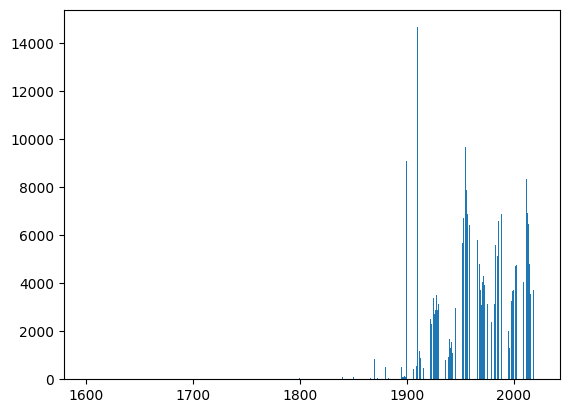

In [73]:
plt.hist(df_Buildings_geo_NAD83[df_Buildings_geo_NAD83['ANNEE_CONS'] != 9999]['ANNEE_CONS'], bins=1000)
plt.show()

In [74]:
fire_counts['cell_id'].unique()

array(['0_1', '10_11', '10_12', '10_13', '10_14', '10_15', '11_12',
       '11_13', '11_14', '11_15', '11_16', '12_13', '12_14', '12_15',
       '12_16', '13_14', '13_15', '13_16', '14_15', '14_16', '1_0', '1_1',
       '1_10', '1_11', '1_12', '1_13', '1_2', '1_3', '1_4', '2_1', '2_10',
       '2_11', '2_12', '2_13', '2_14', '2_2', '2_3', '2_4', '2_5', '2_6',
       '2_7', '2_8', '2_9', '3_1', '3_10', '3_11', '3_12', '3_13', '3_14',
       '3_15', '3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9',
       '4_1', '4_10', '4_11', '4_12', '4_13', '4_14', '4_2', '4_3', '4_4',
       '4_5', '4_6', '4_7', '4_8', '4_9', '5_10', '5_11', '5_12', '5_13',
       '5_14', '5_15', '5_2', '5_3', '5_4', '5_5', '5_6', '5_7', '5_8',
       '5_9', '6_10', '6_11', '6_12', '6_13', '6_14', '6_3', '6_4', '6_5',
       '6_8', '6_9', '7_10', '7_11', '7_12', '7_13', '7_14', '7_15',
       '7_9', '8_10', '8_11', '8_12', '8_13', '8_14', '8_15', '9_10',
       '9_11', '9_12', '9_13', '9_14', '9_15'], dtype=obj

In [75]:
# #Create full (grid, year-month) combinations
# all_year_months = pd.period_range('2005-09', '2025-09', freq='M').astype(str)
# #grid_ids = fishnet_grid_gdf.cell_id
# grid_ids = fire_in_grid.cell_id
# #grid_ids = fire_counts.cell_id

# grid_time_index = pd.MultiIndex.from_product(
#     [grid_ids, all_year_months],
#     #names=['index_right', 'year_month']
#     names=['cell_id', 'year_month']
# )

# base_df = pd.DataFrame(index=grid_time_index).reset_index()
# base_df

In [76]:
# removing data before 2005-09
sub_fire_counts = fire_counts[fire_counts['year_month'] >= '2005-09']
sub_fire_counts

,cell_id,year_month,fire_count
0,0_1,2005-09,1
1,0_1,2005-10,1
2,0_1,2006-02,1
3,0_1,2006-03,1
4,0_1,2006-08,3
...,...,...,...
23814,9_15,2025-05,5
23815,9_15,2025-06,13
23816,9_15,2025-07,15
23817,9_15,2025-08,17


In [77]:
#date_times = pd.to_datetime(fire_counts['year_month'], format='%Y-%m').dt.to_period('M')
#date_times
# Print the year-month from the sub_fire_counts to see min and max in the next cell

date_times = pd.to_datetime(sub_fire_counts['year_month'], format='%Y-%m').dt.strftime('%Y-%m')
date_times




,year_month
0,2005-09
1,2005-10
2,2006-02
3,2006-03
4,2006-08
...,...
23814,2025-05
23815,2025-06
23816,2025-07
23817,2025-08


In [78]:
# print the earliest and latest year_month from the sub_fire_counts
min_date = date_times.min()
max_date = date_times.max()
print(min_date, max_date)

2005-09 2025-09


In [79]:
# print all the year-month
all_periods = pd.period_range(min_date, max_date, freq='M')
all_periods

PeriodIndex(['2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02',
             '2006-03', '2006-04', '2006-05', '2006-06',
             ...
             '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05',
             '2025-06', '2025-07', '2025-08', '2025-09'],
            dtype='period[M]', length=241)

In [80]:
#create a pivot table of year_month and cell_id
pivot_fire_counts = sub_fire_counts.pivot(index='cell_id', columns='year_month', values='fire_count')
pivot_fire_counts

year_month,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,...,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09
cell_id,,,,,,,,,,,,,,,,,,,,,
0_1,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
10_11,7.0,13.0,9.0,9.0,9.0,8.0,5.0,15.0,18.0,13.0,...,16.0,12.0,6.0,16.0,20.0,18.0,22.0,16.0,18.0,11.0
10_12,27.0,15.0,21.0,16.0,17.0,11.0,15.0,17.0,16.0,15.0,...,23.0,26.0,16.0,21.0,23.0,23.0,21.0,22.0,15.0,13.0
10_13,8.0,6.0,12.0,11.0,18.0,8.0,11.0,5.0,11.0,11.0,...,14.0,13.0,8.0,11.0,5.0,13.0,10.0,16.0,14.0,7.0
10_14,8.0,11.0,1.0,8.0,10.0,6.0,7.0,13.0,13.0,5.0,...,16.0,7.0,10.0,14.0,11.0,15.0,10.0,13.0,9.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_11,23.0,21.0,28.0,21.0,18.0,13.0,23.0,21.0,20.0,12.0,...,24.0,26.0,28.0,22.0,27.0,27.0,29.0,33.0,23.0,25.0
9_12,21.0,17.0,18.0,14.0,16.0,15.0,23.0,27.0,15.0,20.0,...,20.0,21.0,15.0,16.0,24.0,18.0,16.0,10.0,15.0,14.0
9_13,28.0,32.0,25.0,31.0,22.0,22.0,17.0,21.0,23.0,28.0,...,25.0,22.0,26.0,25.0,27.0,30.0,26.0,26.0,37.0,19.0


In [81]:
pivot_fire_counts = pivot_fire_counts.fillna(0)
pivot_fire_counts

year_month,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,...,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09
cell_id,,,,,,,,,,,,,,,,,,,,,
0_1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10_11,7.0,13.0,9.0,9.0,9.0,8.0,5.0,15.0,18.0,13.0,...,16.0,12.0,6.0,16.0,20.0,18.0,22.0,16.0,18.0,11.0
10_12,27.0,15.0,21.0,16.0,17.0,11.0,15.0,17.0,16.0,15.0,...,23.0,26.0,16.0,21.0,23.0,23.0,21.0,22.0,15.0,13.0
10_13,8.0,6.0,12.0,11.0,18.0,8.0,11.0,5.0,11.0,11.0,...,14.0,13.0,8.0,11.0,5.0,13.0,10.0,16.0,14.0,7.0
10_14,8.0,11.0,1.0,8.0,10.0,6.0,7.0,13.0,13.0,5.0,...,16.0,7.0,10.0,14.0,11.0,15.0,10.0,13.0,9.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_11,23.0,21.0,28.0,21.0,18.0,13.0,23.0,21.0,20.0,12.0,...,24.0,26.0,28.0,22.0,27.0,27.0,29.0,33.0,23.0,25.0
9_12,21.0,17.0,18.0,14.0,16.0,15.0,23.0,27.0,15.0,20.0,...,20.0,21.0,15.0,16.0,24.0,18.0,16.0,10.0,15.0,14.0
9_13,28.0,32.0,25.0,31.0,22.0,22.0,17.0,21.0,23.0,28.0,...,25.0,22.0,26.0,25.0,27.0,30.0,26.0,26.0,37.0,19.0


In [82]:
# fire_counts dataframe from earliest month to latest month, ready for merging
final_fire_counts = pivot_fire_counts.stack().reset_index(name = "number_of_fires")
final_fire_counts

,cell_id,year_month,number_of_fires
0,0_1,2005-09,1.0
1,0_1,2005-10,1.0
2,0_1,2005-11,0.0
3,0_1,2005-12,0.0
4,0_1,2006-01,0.0
...,...,...,...
27710,9_15,2025-05,5.0
27711,9_15,2025-06,13.0
27712,9_15,2025-07,15.0
27713,9_15,2025-08,17.0


In [83]:
final_fire_counts['number_of_fires'] = final_fire_counts['number_of_fires'].astype(int)
final_fire_counts

,cell_id,year_month,number_of_fires
0,0_1,2005-09,1
1,0_1,2005-10,1
2,0_1,2005-11,0
3,0_1,2005-12,0
4,0_1,2006-01,0
...,...,...,...
27710,9_15,2025-05,5
27711,9_15,2025-06,13
27712,9_15,2025-07,15
27713,9_15,2025-08,17


In [84]:
# fire counts before adding the year-month without fire incident
sub_fire_counts

,cell_id,year_month,fire_count
0,0_1,2005-09,1
1,0_1,2005-10,1
2,0_1,2006-02,1
3,0_1,2006-03,1
4,0_1,2006-08,3
...,...,...,...
23814,9_15,2025-05,5
23815,9_15,2025-06,13
23816,9_15,2025-07,15
23817,9_15,2025-08,17


In [86]:
#final_fire_counts['number_of_fires'] - (# fire counts before adding the year-month without fire incident)
27715-23053

4662

In [87]:
print(final_fire_counts.columns)

Index(['cell_id', 'year_month', 'number_of_fires'], dtype='object')


In [158]:
# Merge fire counts and building attributes
#final_df = final_fire_counts.merge(bld_agg, on='cell_id', how='outer')
# 2025-10-18 4pm Pak: outer will produce NaN in final_df
final_df = final_fire_counts.merge(bld_agg, on='cell_id', how='inner')




#final_df = final_fire_counts.merge(bld_agg, on='cell_id', how='left')

# Convert to Period type for sorting and date context
final_df['year_month'] = pd.PeriodIndex(final_df['year_month'], freq='M')

final_df

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year
0,0_1,2005-09,1,37,1.459459,1976.0
1,0_1,2005-10,1,37,1.459459,1976.0
2,0_1,2005-11,0,37,1.459459,1976.0
3,0_1,2005-12,0,37,1.459459,1976.0
4,0_1,2006-01,0,37,1.459459,1976.0
...,...,...,...,...,...,...
26505,9_15,2025-05,5,3831,1.542678,1973.0
26506,9_15,2025-06,13,3831,1.542678,1973.0
26507,9_15,2025-07,15,3831,1.542678,1973.0
26508,9_15,2025-08,17,3831,1.542678,1973.0


In [159]:
# Sam - team meeting - 19Oct25 - start
pd.reset_option("all")
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 0)
#pd.set_option('display.max_colwidth', None)
#print(not_in_df2[['cell_id','year_month','number_of_fires','num_buildings']])
#print((not_in_df2['number_of_fires'].mean()))
# Sam - team meeting - 19Oct25 - end

In [160]:
final_df.isnull().sum()

,0
cell_id,0
year_month,0
number_of_fires,0
num_buildings,0
avg_floors,0
median_construction_year,0


In [149]:
final_df.shape

(26510, 6)

In [150]:
final_df.columns

Index(['cell_id', 'year_month', 'number_of_fires', 'num_buildings',
       'avg_floors', 'median_construction_year'],
      dtype='object')

In [151]:
final_df['Target_Variable'] = final_df['number_of_fires']>0
final_df['Target_Variable'] = final_df['number_of_fires']>0
final_df['Target_Variable'] = final_df['Target_Variable'].astype(int)
final_df['median_construction_year'] = final_df['median_construction_year'].astype(int)

In [152]:
final_df.head()

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable
0,0_1,2005-09,1,37,1.459459,1976,1
1,0_1,2005-10,1,37,1.459459,1976,1
2,0_1,2005-11,0,37,1.459459,1976,0
3,0_1,2005-12,0,37,1.459459,1976,0
4,0_1,2006-01,0,37,1.459459,1976,0


In [153]:
final_df.to_csv('final_df.csv', index=False)
print("final_df.csv has been saved.")

final_df.csv has been saved.


In [154]:
print(sum(final_df['Target_Variable']==True),sum(final_df['Target_Variable']==False))

print((final_df['Target_Variable']==True).sum(),(final_df['Target_Variable']==False).sum())

23003 3507
23003 3507


In [96]:
target_variable_distribution = final_df['Target_Variable'].value_counts()
print("Distribution of Target_Variable:")
print(target_variable_distribution)

Distribution of Target_Variable:
Target_Variable
1    23003
0     3507
Name: count, dtype: int64


Descriptive statistics for fire_count:


,number_of_fires
count,26510.000000
mean,14.426594
std,20.980646
min,0.000000
25%,2.000000
50%,8.000000
75%,19.000000
max,242.000000


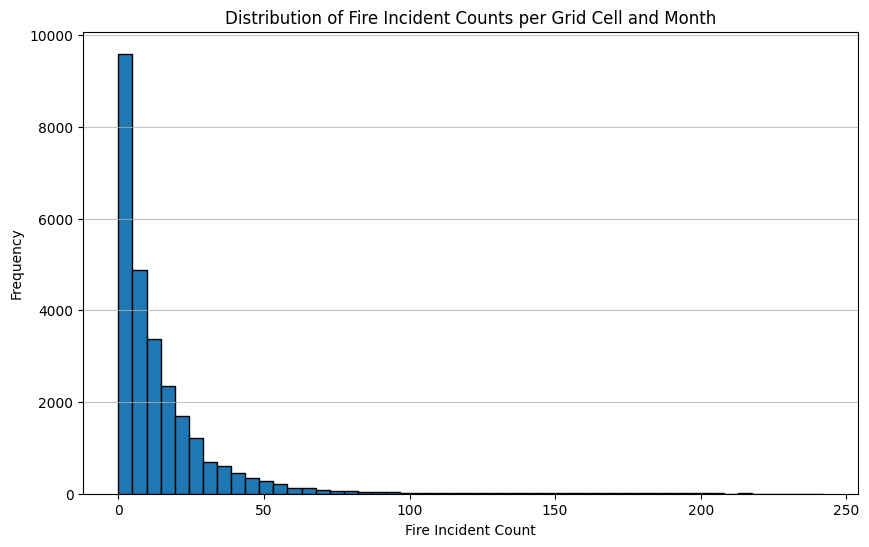

In [97]:
print("Descriptive statistics for fire_count:")
display(final_df['number_of_fires'].describe())

plt.figure(figsize=(10, 6))
plt.hist(final_df['number_of_fires'], bins=50, edgecolor='black')
plt.title('Distribution of Fire Incident Counts per Grid Cell and Month')
plt.xlabel('Fire Incident Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [98]:
final_df_sorted_desc = final_df.sort_values(by='number_of_fires', ascending=False)
display(final_df_sorted_desc.head())

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable
17561,5_13,2023-02,242,23085,1.331297,1994,1
17581,5_13,2024-10,242,23085,1.331297,1994,1
17583,5_13,2024-12,240,23085,1.331297,1994,1
17392,5_13,2009-01,237,23085,1.331297,1994,1
17577,5_13,2024-06,235,23085,1.331297,1994,1


In [99]:
cell_5_13_data = final_df_sorted_desc[final_df_sorted_desc['cell_id'] == '6_13']
display(cell_5_13_data)

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable
20521,6_13,2008-09,133,18942,1.660648,1952,1
20702,6_13,2023-10,121,18942,1.660648,1952,1
20567,6_13,2012-07,115,18942,1.660648,1952,1
20532,6_13,2009-08,114,18942,1.660648,1952,1
20522,6_13,2008-10,111,18942,1.660648,1952,1
...,...,...,...,...,...,...,...
20619,6_13,2016-11,46,18942,1.660648,1952,1
20609,6_13,2016-01,45,18942,1.660648,1952,1
20587,6_13,2014-03,45,18942,1.660648,1952,1
20562,6_13,2012-02,44,18942,1.660648,1952,1


In [100]:
final_df_sorted_desc.head(25)

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable
17561,5_13,2023-02,242,23085,1.331297,1994,1
17581,5_13,2024-10,242,23085,1.331297,1994,1
17583,5_13,2024-12,240,23085,1.331297,1994,1
17392,5_13,2009-01,237,23085,1.331297,1994,1
17577,5_13,2024-06,235,23085,1.331297,1994,1
17589,5_13,2025-06,229,23085,1.331297,1994,1
17578,5_13,2024-07,227,23085,1.331297,1994,1
17353,5_13,2005-10,226,23085,1.331297,1994,1
17569,5_13,2023-10,225,23085,1.331297,1994,1
17391,5_13,2008-12,222,23085,1.331297,1994,1


In [101]:
final_df.isnull().sum()

,0
cell_id,0
year_month,0
number_of_fires,0
num_buildings,0
avg_floors,0
median_construction_year,0
Target_Variable,0


In [102]:
final_df[final_df.notnull()]

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable
0,0_1,2005-09,1,37,1.459459,1976,1
1,0_1,2005-10,1,37,1.459459,1976,1
2,0_1,2005-11,0,37,1.459459,1976,0
3,0_1,2005-12,0,37,1.459459,1976,0
4,0_1,2006-01,0,37,1.459459,1976,0
...,...,...,...,...,...,...,...
26505,9_15,2025-05,5,3831,1.542678,1973,1
26506,9_15,2025-06,13,3831,1.542678,1973,1
26507,9_15,2025-07,15,3831,1.542678,1973,1
26508,9_15,2025-08,17,3831,1.542678,1973,1


In [103]:
nan_rows = final_df[final_df.isnull().any(axis=1)]
nan_rows
#print(nan_rows.shape[0], final_df.shape[0])

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable


In [104]:
nan_rows = final_df[final_df.isnull().any(axis=1)]
nan_rows

,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable


# Temporal Lags (Feature Engineering)

In [163]:
# Sort by cell and time for lag computation
print("Creating temporal lag features...")
final_df = final_df.sort_values(['cell_id', 'year_month'])

# Create lagged fire count variables (1, 2, 3, 6, 12 months)
for lag in [1, 2, 3, 6, 12]:
    final_df[f'fires_lag_{lag}m'] = (
        final_df
        .groupby('cell_id')['number_of_fires']
        .shift(lag)
        .fillna(0)
    )
    print(f"Created fires_lag_{lag}m")

# Lagged binary target variables (for autoregressive models)
for lag in [1, 2, 3]:
    final_df[f'target_lag_{lag}m'] = (
        final_df
        .groupby('cell_id')['number_of_fires']
        .shift(lag)
        .fillna(0)
    )
    print(f"Created target_lag_{lag}m")

print(f"\nTemporal lag features added successfully")
print(f"New shape: {final_df.shape}")

Creating temporal lag features...
Created fires_lag_1m
Created fires_lag_2m
Created fires_lag_3m
Created fires_lag_6m
Created fires_lag_12m
Created target_lag_1m
Created target_lag_2m
Created target_lag_3m

Temporal lag features added successfully
New shape: (26510, 15)


# Seasonality

In [164]:
# Extract month and year
print("Creating seasonality features...")
final_df['month'] = final_df['year_month'].dt.month
final_df['year'] = final_df['year_month'].dt.year

# Sine/cosine transformations for circular encoding
final_df['month_sin'] = np.sin(2 * np.pi * final_df['month'] / 12)
final_df['month_cos'] = np.cos(2 * np.pi * final_df['month'] / 12)

print("Seasonality features created:")
print("  - month (1-12)")
print("  - year")
print("  - month_sin (circular encoding)")
print("  - month_cos (circular encoding)")

#  Sample values for different months
print("\nSample seasonality values:")
example_months = final_df[['month', 'month_sin', 'month_cos']].drop_duplicates().sort_values('month')
print(example_months.head(12))

Creating seasonality features...
Seasonality features created:
  - month (1-12)
  - year
  - month_sin (circular encoding)
  - month_cos (circular encoding)

Sample seasonality values:
    month     month_sin     month_cos
4       1  5.000000e-01  8.660254e-01
5       2  8.660254e-01  5.000000e-01
6       3  1.000000e+00  6.123234e-17
7       4  8.660254e-01 -5.000000e-01
8       5  5.000000e-01 -8.660254e-01
9       6  1.224647e-16 -1.000000e+00
10      7 -5.000000e-01 -8.660254e-01
11      8 -8.660254e-01 -5.000000e-01
0       9 -1.000000e+00 -1.836970e-16
1      10 -8.660254e-01  5.000000e-01
2      11 -5.000000e-01  8.660254e-01
3      12 -2.449294e-16  1.000000e+00


# Spatial Lags

In [165]:
# Build neighbor mapping (4-neighbor: North, South, East, West)
# Only include neighbors that actually exist in the dataset
print("Building spatial adjacency structure...")
neighbor_map = {}

# Get all valid cell_ids as a set for fast lookup
valid_cells = set(final_df['cell_id'].unique())
# sam - start(1)
#cellsLst = []
#print("start - lst cells")
# sam - end(1)
for cell_id in valid_cells:
    row_str, col_str = cell_id.split('_')
    row, col = int(row_str), int(col_str)
    # sam - start(2)
    #cellsLst.append([row, col])
    #print([row, col])
    #print("end - lst cells")
    # sam - end(2)
    # Candidate neighbors (4-neighbor: cardinal directions)
    candidates = [
        f"{row-1}_{col}",  # North
        f"{row+1}_{col}",  # South
        f"{row}_{col-1}",  # West
        f"{row}_{col+1}"   # East
    ]

    # Keep only neighbors that actually exist in the dataset
    neighbors = [n for n in candidates if n in valid_cells]
    neighbor_map[cell_id] = neighbors

print(f"Neighbor map created for {len(neighbor_map):,} cells")

# Analyze neighbor distribution to understand edge effects
neighbor_counts = {cell: len(neighbors) for cell, neighbors in neighbor_map.items()}
print("\nNeighbor count distribution:")
print(f"  Cells with 2 neighbors (corners): {sum(1 for c in neighbor_counts.values() if c == 2)}")
print(f"  Cells with 3 neighbors (edges): {sum(1 for c in neighbor_counts.values() if c == 3)}")
print(f"  Cells with 4 neighbors (interior): {sum(1 for c in neighbor_counts.values() if c == 4)}")

# Sam [19-Oct-2025] - start
print(f"  Cells with 1 neighbor (corners): {sum(1 for c in neighbor_counts.values() if c == 1)}")

ttl = 0
for i in range(1,5):
  ttl += sum(1 for c in neighbor_counts.values() if c == i)
print(ttl)
# Sam [19-Oct-2025] - end

Building spatial adjacency structure...
Neighbor map created for 110 cells

Neighbor count distribution:
  Cells with 2 neighbors (corners): 19
  Cells with 3 neighbors (edges): 25
  Cells with 4 neighbors (interior): 65
  Cells with 1 neighbor (corners): 1
110


In [162]:
# Compute spatial lag with TEMPORAL LAG to avoid data leakage

print("\nComputing spatial lag features with temporal lag (this may take a few minutes)...")


def get_neighbor_fires_lagged(row):
    """
    Sum of fire counts in neighboring cells from PREVIOUS month.
    This avoids data leakage by not using concurrent fire information.
    """
    cell = row['cell_id']
    current_period = row['year_month']
    neighbors = neighbor_map.get(cell, [])

    if len(neighbors) == 0:
        return 0

    # Get previous month (temporal lag)
    current_date = pd.to_datetime(str(current_period))
    previous_period = (current_date - pd.DateOffset(months=1)).to_period('M')

    neighbor_data = final_df[
        (final_df['cell_id'].isin(neighbors)) &
        (final_df['year_month'] == previous_period)
    ]

    return neighbor_data['number_of_fires'].sum()

def get_neighbor_targets_lagged(row):
    """
    Number of neighboring cells with fires in PREVIOUS month.
    This avoids data leakage by not using concurrent fire information.
    """
    cell = row['cell_id']
    current_period = row['year_month']
    neighbors = neighbor_map.get(cell, [])

    if len(neighbors) == 0:
        return 0

    # Get previous month (temporal lag)
    current_date = pd.to_datetime(str(current_period))
    previous_period = (current_date - pd.DateOffset(months=1)).to_period('M')

    neighbor_data = final_df[
        (final_df['cell_id'].isin(neighbors)) &
        (final_df['year_month'] == previous_period)
    ]

    return neighbor_data['number_of_fires'].sum()

def get_neighbor_count(row):
    """Number of valid neighbors for this cell (to identify border cells)"""
    cell = row['cell_id']
    neighbors = neighbor_map.get(cell, [])
    return len(neighbors)

# Spatial lag computation
print("Computing spatial lag features...")
final_df['neighbors_fires_lag1m'] = final_df.apply(get_neighbor_fires_lagged, axis=1)
final_df['neighbors_target_lag1m'] = final_df.apply(get_neighbor_targets_lagged, axis=1)
final_df['neighbor_count'] = final_df.apply(get_neighbor_count, axis=1)

# Normalized version (average per neighbor to handle edge effects)
final_df['neighbors_fires_avg'] = final_df['neighbors_fires_lag1m'] / final_df['neighbor_count']
final_df['neighbors_fires_avg'] = final_df['neighbors_fires_avg'].fillna(0)

print("\nSpatial lag features created:")
print("   neighbors_fires_lag1m (sum of fires in adjacent cells from previous month)")
print("   neighbors_target_lag1m (count of adjacent cells with fires from previous month)")
print("   neighbor_count (number of valid neighbors - identifies border cells)")
print("   neighbors_fires_avg (average fires per neighbor - normalized for edge effects)")

print(f"\nSpatial lag statistics:")
print(final_df[['neighbors_fires_lag1m', 'neighbors_target_lag1m', 'neighbor_count', 'neighbors_fires_avg']].describe())




Computing spatial lag features with temporal lag (this may take a few minutes)...
Computing spatial lag features...


KeyError: 'Target_Variable'

## Visualize Edge Effects and Spatial Structure